In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

class MyModel(BaseEstimator, ClassifierMixin):
    def __init__(self, C=100, kernel='rbf', gamma=0.001, n_components=0.98, variance_t=0.001, corr_t= 0.9,resample=False, random_state=None):
        """
        Initialize the MyModel with hyperparameters.

        Parameters:
        - C: Regularization parameter
        - kernel: Kernel function for the SVM ('linear', 'rbf', 'poly', etc.)
        - gamma: Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
        - random_state: Seed for random number generation
        """
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.random_state = random_state
        self.n_components = n_components
        self.variance_t = variance_t
        self.corr_t = corr_t
        self.model = None
        self.drop = None
        self.sscaler = None,
        self.pcac = None
        self.resample = resample

    def fit(self, x_train, y_train):
        """
        Fit the SVM model to the training data.

        Parameters:
        - X: Training data features
        - y: Target labels
        """
        
        if(self.resample):
            # Instantiate SMOTE with desired sampling strategy
            smote = SMOTE(sampling_strategy='auto', random_state=42)  # You can adjust the sampling strategy

            # Fit and transform the dataset
            x_resampled, y_resampled = smote.fit_resample(x_train, y_train)
        else:
            x_resampled, y_resampled = x_train, y_train
            
        #using variance threshold
        self.drop = self.variance_treshould_invf(x_resampled)
        
        vx_train = x_resampled.drop(columns=self.drop,axis=1)
        
        # using correlation
#         next_drop = self.correlation(vx_train)
        next_drop = set()
        self.drop = self.drop + list(next_drop)
        
        cvx_train = vx_train.drop(columns=next_drop,axis=1)
        
        self.sscaler = StandardScaler()

        # fit the scaler
        scvx_train = pd.DataFrame(self.sscaler.fit_transform(cvx_train), columns=cvx_train.columns)
        
        # define the pca
        if(self.n_components):
            self.pcac = PCA(n_components= self.n_components)

            pscvx_train = self.pcac.fit_transform(scvx_train)
            print(f"No of new Lables: {len(pscvx_train[0])}")
        else:
            pscvx_train = scvx_train
        
        
        self.model = SVC(C=self.C, kernel=self.kernel, gamma=self.gamma, random_state=self.random_state, class_weight="balanced")
        self.model.fit(pscvx_train, y_resampled)

    def predict(self, X):
        """
        Make predictions using the trained SVM model.

        Parameters:
        - X: Input data for predictions

        Returns:
        - Predicted labels
        """
        
        if self.model is None:
            raise ValueError("Model has not been trained. Please call fit() first.")
            
        cvx_valid = X.drop(columns=self.drop,axis=1)
        
        scvx_valid = pd.DataFrame(self.sscaler.transform(cvx_valid), columns=cvx_valid.columns)
        
        if self.n_components:
            pscvx_valid = self.pcac.transform(scvx_valid)
        else:
            pscvx_valid = scvx_valid
        return self.model.predict(pscvx_valid)
    
    def variance_treshould_invf(self, X):
        should_drop = []
        stds = X.describe().loc["std"]
        max_variance = max(stds)**2
        for i in range(0, len(stds)):
            if (stds[i]**2)< (self.variance_t):
                should_drop.append(f"feature_{i+1}")
        return should_drop
    
    def correlation(self, X):
      col_corr = set()
      corr_matrix = X.corr()
      for i in range(len(corr_matrix.columns)):
        for j in range(i):
          if abs(corr_matrix.iloc[i,j])>= self.corr_t:
            colname = corr_matrix.columns[i]
            col_corr.add(colname)
      return col_corr

    def getValidationSet(self):
        return self.x_valid

In [8]:
def append_to_file(text):
    with open("outputs2.txt", "a") as file:
        # Write content to the file
        file.write(f"{text}\n")

In [9]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import cross_val_score
import numpy as np

all_labels = ["label_1","label_2","label_3", "label_4"]
for label in all_labels:
    droping_labels = all_labels.copy()
    droping_labels.remove(label)
    
    train = pd.read_csv("./train.csv")
    valid = pd.read_csv("./valid.csv")

    train.drop(droping_labels, axis=1, inplace=True)
    valid.drop(droping_labels, axis=1, inplace=True)
    
    if(len(train.columns[train.isnull().any()])>0):
        print(f"{label} has missing values in train set")
        train.dropna(inplace=True)
        
    if(len(valid.columns[train.isnull().any()])>0):
        print(f"{label} has missing values in valid set")
        valid.dropna(inplace=True)
    
    # splitting features and the label
    x_train = train.drop([label], axis=1)
    y_train = train[label]
    x_valid = valid.drop([label], axis=1)
    y_valid = valid[label]
    
    
    # Create an instance of MyModel
    my_model = MyModel()

    # Fit the model to the training data
    my_model.fit(x_train, y_train)

    # Make predictions on the test data
    y_pred = my_model.predict(x_valid)

    # Print the accuracy of the model
    accuracy = (y_pred == y_valid).mean()
    print(f"Accuracy for {label}: {accuracy}")
    append_to_file(f"Initial accuracy for {label}: {accuracy}")
    break

    # Example of using RandomizedSearchCV to tune hyperparameters
    param_dist = {
        'C': uniform(0.1, 100.0),
        'kernel': ['linear', 'rbf'],
        'gamma': uniform(0.001, 0.1),
        'n_components': [0.99, 0.98, 0.97],
        'variance_t': [0.001],
        'corr_t': [None],
        'resample': [False]
    }

    random_search = RandomizedSearchCV(
        estimator=my_model,
        param_distributions=param_dist,
        n_iter=20,  # Number of random combinations to try
        cv=5,  # Number of cross-validation folds
        verbose=2,
        random_state=42,  # Set a random seed for reproducibility
        n_jobs=-1  # Use all available CPU cores for parallel computation
    )
    random_search.fit(x_train, y_train)

    print("Best hyperparameters found by RandomizedSearchCV:")
    print(random_search.best_params_)
    append_to_file(f"Best params for {label} : {random_search.best_params_}")
    
    print("Best Score:", random_search.best_score_)
    append_to_file(f"Best score for {label} : {random_search.best_score_}")
    
    # Perform cross-validation to evaluate the model with the best hyperparameters
#     cross_val_scores = cross_val_score(random_search, X, y, cv=5, n_jobs=-1)

    # Print cross-validation scores
#     print("Cross-Validation Scores:", cross_val_scores)
#     append_to_file(f"Cross-Validation Scores for {label} : {cross_val_scores} \n")
#     print("Mean CV Score:", np.mean(cross_val_scores))
#     append_to_file(f"Mean CV Score for {label} : {np.mean(cross_val_scores)}")


No of new Lables: 468
Accuracy for label_1: 0.96


In [11]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import cross_val_score
import numpy as np

In [34]:
train = pd.read_csv("./train.csv")
valid = pd.read_csv("./valid.csv")

In [29]:
train.dropna(inplace=True)

In [30]:
counts = train['label_2'].isnull().sum()

In [31]:
counts

0

In [21]:
import matplotlib.pyplot as plt

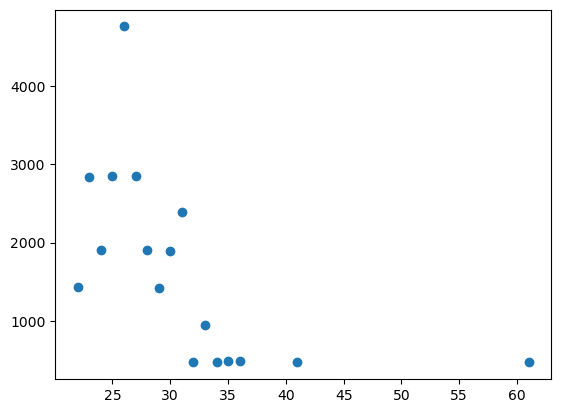

In [22]:
plt.scatter(counts.index, counts['feature_1'])

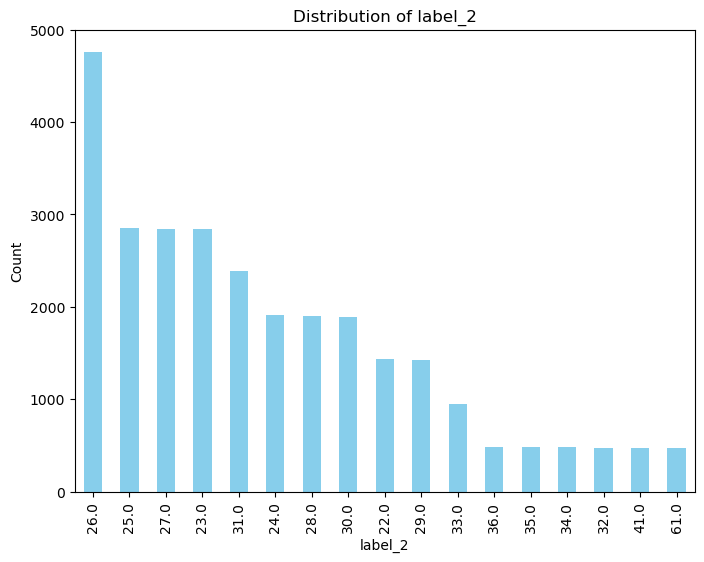

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called x_train with a 'label_2' column
# Replace 'label_2' with the actual name of your column
column_name = 'label_2'

# Check if the column exists in the DataFrame
if column_name in train.columns:
    # Plot the distribution
    plt.figure(figsize=(8, 6))
    train[column_name].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.show()
else:
    print(f"'{column_name}' column not found in the DataFrame.")
